In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob
import random
import shutil
from keras.preprocessing.image import load_img, img_to_array

img_path="data/images/"
img_height=224 #299
img_width=224 #299

# credit: https://github.com/fastai/fastai/blob/9e9ffbd49eb6490bb1168ce2ff32b10a81498ba9/fastai/utils.py
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def plot_img(img, title, count, cols, plot_axis=False):
    a = fig.add_subplot(1, cols, count)
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        plt.imshow(img)
    else:
        plt.imshow(load_img(img))
    a.set_title(title,fontsize=10)
    if plot_axis is False:
        plt.axis('off')

/home/ubuntu/anaconda2/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda2/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [42]:
import csv

def create_label_directories(csv_filename, img_path, is_one_v_all=False, one_v_all_label="Fibrosis"):
    directories = set()
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                if (is_one_v_all is True) and (label != one_v_all_label):
                    label = "ALL"
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path,"valid",label)
                dst_test_dir = os.path.join(img_path,"test",label)
                if not os.path.exists(dst_train_dir):
                    os.makedirs(dst_train_dir)
                    directories.add(label)
                if not os.path.exists(dst_valid_dir):
                    os.makedirs(dst_valid_dir)
                if not os.path.exists(dst_test_dir):
                    os.makedirs(dst_test_dir)
                src_file_abs = os.path.join(os.getcwd(),src_file)
                dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                if not os.path.exists(dst_train_file_abs):
                    os.symlink(src_file_abs, dst_train_file_abs)
    return list(directories)

is_one_v_all = True
one_v_all_label = "Fibrosis"
print(img_path)
directories = create_label_directories("data/Data_Entry_2017.csv", img_path, is_one_v_all, one_v_all_label)
print(directories)

data/images/
['Fibrosis', 'ALL']


In [43]:
def get_per_label_count(directories):
    per_label_count = []
    for ii in range(len(directories)):
        #print(directories[ii])
        path, dirs, files = os.walk(os.path.join(img_path,"train",directories[ii])).__next__()
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(directories)
per_label_count = get_per_label_count(directories) 
print(per_label_count)

['Fibrosis', 'ALL']
[1686, 111393]


In [9]:
import subprocess

def upsample(directories, per_label_count, iqr):
    for ii in range(len(per_label_count)):
        label = directories[ii]
        count = per_label_count[ii]
        if count < iqr:
            offset = iqr-count
            subprocess.call(['./batch-augment.sh', os.path.join(os.getcwd(),img_path,"train",label), str(offset)])
    return get_per_label_count(directories)

print(directories)
print(per_label_count)
#print(label_batch_size)
per_label_count_upsampled = upsample(directories, per_label_count, 8430)#label_batch_size)
print(per_label_count_upsampled)

['Fibrosis', 'ALL']
[1686, 111393]
[8430, 1686]


In [18]:
def downsample(directories, per_label_count):
    label_idx = np.argmin(per_label_count)
    #print(label_idx)
    downsample_count = per_label_count[label_idx]
    #print(downsample_count)
    for ii in range(len(per_label_count)):
        label = directories[ii]
        src_train_dir = os.path.join(img_path,"train",label)
        all_img_paths = glob.glob(os.path.join(src_train_dir,"*.*"))
        np.random.shuffle(all_img_paths)
        if len(all_img_paths) != downsample_count:
            imgs_to_remove = all_img_paths[downsample_count:]
            #print(len(imgs_to_remove))
            for file in imgs_to_remove:
                file_abs = os.path.join(os.getcwd(),file)
                #print("remove file: " + file_abs)
                os.remove(file_abs)
    return get_per_label_count(directories)
                
print(directories)
print(per_label_count_upsampled)
per_label_count_downsampled = downsample(directories, per_label_count_upsampled)
print(per_label_count_downsampled)

['Fibrosis', 'ALL']
[8430, 111393]
[8430, 8430]


In [44]:
def split_train_valid_test(directories, per_label_count, valid_pct, test_pct):
    for ii in range(len(directories)):
        all_img_paths = glob.glob(os.path.join(img_path,"train",directories[ii],"*.*"))
        np.random.shuffle(all_img_paths)
        label_count = per_label_count[ii]
        valid_count = int(label_count*valid_pct)
        valid_files = all_img_paths[:valid_count]
        all_img_paths[:valid_count] = []
        test_count = int(label_count*test_pct)
        test_files = all_img_paths[:test_count]
        all_img_paths[:test_count] = []
        #print(len(valid_files))
        #print(len(test_files))
        train_files = all_img_paths
        all_img_paths = []
        #print(len(train_files))
        for valid_file in valid_files:
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            #print("move: '" + valid_file_abs + "' to: '" + os.path.join(img_path,"valid",directories[ii]))
            shutil.move(valid_file_abs, os.path.join(img_path,"valid",directories[ii]))
        for test_file in test_files:
            test_file_abs = os.path.join(os.getcwd(),test_file)
            #print("move: '" + test_file_abs + "' to: '" + os.path.join(img_path,"test",directories[ii]))
            shutil.move(test_file_abs, os.path.join(img_path,"test",directories[ii]))
        

valid_pct = 0.01 # 0.1
test_pct = 0.98 # 0.1       
#print(resampled_directories)
#print(resampled_per_label_count)
#split_train_valid_test(resampled_directories, resampled_per_label_count, valid_pct, test_pct)
print(directories)
print(per_label_count_downsampled)
split_train_valid_test(directories, per_label_count_downsampled, valid_pct, test_pct)

['Fibrosis', 'ALL']
[8430, 8430]


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    'data/images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    'data/images/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    'data/images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 16188 images belonging to 2 classes.
Found 336 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


In [3]:
from keras.applications.densenet import DenseNet121
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
model.load_weights('weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5')

In [6]:
# only missing -> cmd:option('-weightDecay', 1e-4, 'weight decay')
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=500)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
callbacks_list = [checkpoint,early_stopping]#,tensorboard]

In [7]:
nb_train_samples = 16188 #8094 #3036 #18046 #111589 #113243 #139987 
nb_validation_samples= 336 
epochs = int(nb_train_samples/batch_size)*3
history = model.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/1515
32/32 [==============================] - 56s 2s/step - loss: 0.2267 - acc: 0.9160 - val_loss: 0.2029 - val_acc: 0.9315

Epoch 00001: val_loss improved from inf to 0.20285, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 2/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1878 - acc: 0.9336 - val_loss: 0.2074 - val_acc: 0.9098

Epoch 00002: val_loss did not improve
Epoch 3/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1863 - acc: 0.9365 - val_loss: 0.1761 - val_acc: 0.9426

Epoch 00003: val_loss improved from 0.20285 to 0.17610, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 4/1515
32/32 [==============================] - 50s 2s/step - loss: 0.2176 - acc: 0.9238 - val_loss: 0.1690 - val_acc: 0.9395

Epoch 00004: val_loss improved from 0.17610 to 0.16902, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 5/1515
32/32 [===


Epoch 00044: val_loss did not improve
Epoch 45/1515
32/32 [==============================] - 49s 2s/step - loss: 0.1811 - acc: 0.9450 - val_loss: 0.1533 - val_acc: 0.9577

Epoch 00045: val_loss did not improve
Epoch 46/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1405 - acc: 0.9492 - val_loss: 0.1445 - val_acc: 0.9539

Epoch 00046: val_loss did not improve
Epoch 47/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1423 - acc: 0.9590 - val_loss: 0.1877 - val_acc: 0.9314

Epoch 00047: val_loss did not improve
Epoch 48/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1428 - acc: 0.9541 - val_loss: 0.1272 - val_acc: 0.9621

Epoch 00048: val_loss improved from 0.13893 to 0.12725, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 49/1515
32/32 [==============================] - 50s 2s/step - loss: 0.1524 - acc: 0.9482 - val_loss: 0.1941 - val_acc: 0.9406

Epoch 00049: val_loss did not improve
Ep

32/32 [==============================] - 50s 2s/step - loss: 0.1138 - acc: 0.9609 - val_loss: 0.1441 - val_acc: 0.9559

Epoch 00138: val_loss did not improve
Epoch 139/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0830 - acc: 0.9697 - val_loss: 0.1967 - val_acc: 0.9611

Epoch 00139: val_loss did not improve
Epoch 140/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0939 - acc: 0.9688 - val_loss: 0.1576 - val_acc: 0.9570

Epoch 00140: val_loss did not improve
Epoch 141/1515
32/32 [==============================] - 49s 2s/step - loss: 0.1099 - acc: 0.9658 - val_loss: 0.1975 - val_acc: 0.9232

Epoch 00141: val_loss did not improve
Epoch 142/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0839 - acc: 0.9707 - val_loss: 0.2015 - val_acc: 0.9457

Epoch 00142: val_loss did not improve
Epoch 143/1515
32/32 [==============================] - 48s 2s/step - loss: 0.0872 - acc: 0.9717 - val_loss: 0.1520 - val_acc: 0.9518

Epoch 00143: va

32/32 [==============================] - 49s 2s/step - loss: 0.0899 - acc: 0.9725 - val_loss: 0.3758 - val_acc: 0.8790

Epoch 00232: val_loss did not improve
Epoch 233/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0797 - acc: 0.9707 - val_loss: 0.1729 - val_acc: 0.9621

Epoch 00233: val_loss did not improve
Epoch 234/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0582 - acc: 0.9814 - val_loss: 0.2056 - val_acc: 0.9334

Epoch 00234: val_loss did not improve
Epoch 235/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0635 - acc: 0.9766 - val_loss: 0.2331 - val_acc: 0.9447

Epoch 00235: val_loss did not improve
Epoch 236/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0780 - acc: 0.9727 - val_loss: 0.2146 - val_acc: 0.9365

Epoch 00236: val_loss did not improve
Epoch 237/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0815 - acc: 0.9717 - val_loss: 0.1647 - val_acc: 0.9641

Epoch 00237: va

32/32 [==============================] - 50s 2s/step - loss: 0.0336 - acc: 0.9893 - val_loss: 0.2385 - val_acc: 0.9498

Epoch 00326: val_loss did not improve
Epoch 327/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0467 - acc: 0.9844 - val_loss: 0.2945 - val_acc: 0.9539

Epoch 00327: val_loss did not improve
Epoch 328/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0411 - acc: 0.9844 - val_loss: 0.2375 - val_acc: 0.9355

Epoch 00328: val_loss did not improve
Epoch 329/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0413 - acc: 0.9824 - val_loss: 0.2643 - val_acc: 0.9314

Epoch 00329: val_loss did not improve
Epoch 330/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0609 - acc: 0.9775 - val_loss: 0.2187 - val_acc: 0.9508

Epoch 00330: val_loss did not improve
Epoch 331/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0424 - acc: 0.9854 - val_loss: 0.3199 - val_acc: 0.9506

Epoch 00331: va

32/32 [==============================] - 50s 2s/step - loss: 0.0368 - acc: 0.9873 - val_loss: 0.2855 - val_acc: 0.9416

Epoch 00420: val_loss did not improve
Epoch 421/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0215 - acc: 0.9961 - val_loss: 0.2232 - val_acc: 0.9529

Epoch 00421: val_loss did not improve
Epoch 422/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0222 - acc: 0.9941 - val_loss: 0.2648 - val_acc: 0.9570

Epoch 00422: val_loss did not improve
Epoch 423/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0237 - acc: 0.9932 - val_loss: 0.3988 - val_acc: 0.9488

Epoch 00423: val_loss did not improve
Epoch 424/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0221 - acc: 0.9941 - val_loss: 0.3535 - val_acc: 0.9477

Epoch 00424: val_loss did not improve
Epoch 425/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0319 - acc: 0.9873 - val_loss: 0.3393 - val_acc: 0.9529

Epoch 00425: va

32/32 [==============================] - 49s 2s/step - loss: 0.0198 - acc: 0.9961 - val_loss: 0.3769 - val_acc: 0.9498

Epoch 00514: val_loss did not improve
Epoch 515/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.3793 - val_acc: 0.9488

Epoch 00515: val_loss did not improve
Epoch 516/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0078 - acc: 0.9961 - val_loss: 0.3185 - val_acc: 0.9211

Epoch 00516: val_loss did not improve
Epoch 517/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0147 - acc: 0.9941 - val_loss: 0.3685 - val_acc: 0.9457

Epoch 00517: val_loss did not improve
Epoch 518/1515
32/32 [==============================] - 49s 2s/step - loss: 0.0353 - acc: 0.9883 - val_loss: 0.3791 - val_acc: 0.9234

Epoch 00518: val_loss did not improve
Epoch 519/1515
32/32 [==============================] - 50s 2s/step - loss: 0.0198 - acc: 0.9922 - val_loss: 0.3069 - val_acc: 0.9539

Epoch 00519: va

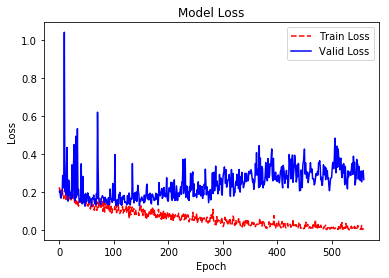

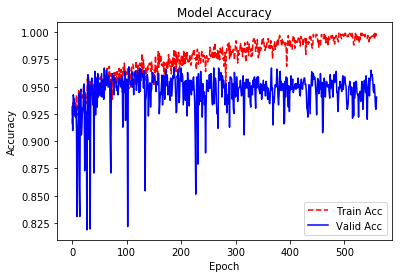

In [8]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [37]:
#nb_test_samples = 168
#steps = nb_test_samples/batch_size
#scores = model.evaluate(X_test, y_test)
scores = model.evaluate_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

score = Loss: 0.136075, Acc@1: 0.95


In [35]:
preds = model.predict_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
preds.shape

(320, 2)

In [73]:
#print(test_generator.classes)
steps = 11 #int(SIZE?/batch_size)
preds = np.zeros((0,2))
y_test = np.zeros((0,2))
step_count = 0
for batch_x, batch_y in test_generator:
    if step_count < steps:
        batch_preds = model.predict(batch_x)
        #print(batch_preds.shape)
        preds = np.vstack((preds,batch_preds))
        #print(batch_y)
        y_test = np.vstack((y_test,batch_y))
        step_count = step_count + 1
    else:
        break
        
print(preds.shape)
print(y_test.shape)

(336, 2)
(336, 2)


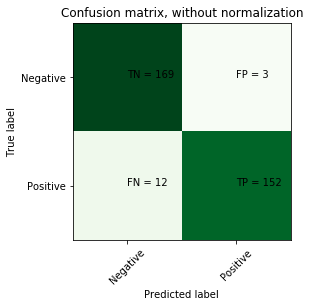

In [77]:
import itertools
from sklearn.metrics import confusion_matrix

y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# credit: https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/    
def plot_binary_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    classNames = classes
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
cm = confusion_matrix(y_trues, y_preds)
#print(cm)
tn, fp, fn, tp = cm.ravel()
#print(tn, fp, fn, tp)

# Plot non-normalized confusion matrix
plt.figure()
plot_binary_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix, without normalization', cmap=plt.cm.Greens)
plt.show()
